# Inference

In this notebook, we will use the trained model to generate captions for images in the test dataset.

Outline of this notebook:
- [Step 1](#step1): Getting Data Loader for Test Dataset 
- [Step 2](#step2): Loading Trained Models
- [Step 3](#step3): Finishing the Sampler
- [Step 4](#step4): Cleaning up Captions
- [Step 5](#step5): Generating Predictions!

<a id='step1'></a>
## Step 1: Getting Data Loader for Test Dataset

Before running the code cell below, I will define the transform in `transform_test` that we would like to use to pre-process the test images.  

This transform must agrees with the transform that we used to pre-process the training images (in **2_Training.ipynb**). For instance, if we normalized the training images, we should also apply the same normalization procedure to the test images.

In [1]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from model import EncoderCNN, DecoderRNN
from nlp_utils import clean_sentence

%matplotlib inline
%load_ext autoreload
%autoreload 2

[nltk_data] Downloading package punkt to /home/masoud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
cocoapi_dir = r"path/to/cocoapi/dir"

# Defining a transform to pre-process the testing images.
transform_test = transforms.Compose(
    [
        transforms.Resize(256),  # smaller edge of image resized to 256
        transforms.RandomCrop(224),  # get 224x224 crop from random location
        transforms.RandomHorizontalFlip(),  # horizontally flip image with probability=0.5
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        ),
    ]
)


# Creating the data loader.
data_loader = get_loader(transform=transform_test, mode="test", cocoapi_loc=cocoapi_dir)

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

torch.Size([1, 512, 640, 3]) torch.Size([1, 3, 224, 224]) torch.Size([512, 640, 3])


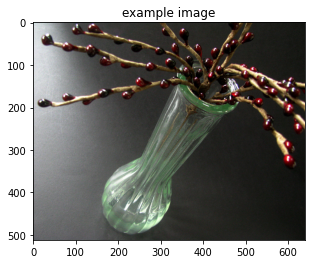

In [3]:
# Obtaining sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

print(orig_image.shape, image.shape, np.squeeze(orig_image).shape)

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title("example image")
plt.show()

<a id='step2'></a>
## Step 2: Loading Trained Models

In the next code cell we define a `device` that we will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In the next code cell, we will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**). To accomplish this, we specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-3.pkl` and `decoder-3.pkl`, if we trained the model for 3 epochs and saved the weights after each epoch).  

The, we plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [5]:
# Specify the saved models to load.
encoder_file = "encoder-3.pkl"
decoder_file = "decoder-3.pkl"

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
encoder.eval()
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join("./models", encoder_file)))
decoder.load_state_dict(torch.load(os.path.join("./models", decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

<a id='step3'></a>
## Step 3: Finishing the Sampler

Before executing the next code cell, please see the `sample` method in the `DecoderRNN` class in **model.py**.  This method accepts as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image. It returns as output a Python list `output`, indicating the predicted sentence. `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence. The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

In [6]:
# Moving image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtaining the embedded image features.
features = encoder(image).unsqueeze(1)

print(features.shape)
# Passing the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print("example output:", output)

assert type(output) == list, "Output needs to be a Python list"
assert all([type(x) == int for x in output]), "Output should be a list of integers."
assert all(
    [x in data_loader.dataset.vocab.idx2word for x in output]
), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 1, 256])
example output: [0, 3, 1845, 21, 765, 6, 3, 216, 13, 278, 1]


<a id='step4'></a>
## Step 4: Cleaning up the Captions

In the code cell below, the `clean_sentence` function takes a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [8]:
sentence = clean_sentence(output, data_loader.dataset.vocab.idx2word)
print("example sentence:", sentence)

assert type(sentence) == str, "Sentence needs to be a Python string!"

example sentence:  a vase with flowers and a glass of water


<a id='step5'></a>
## Step 5: Generating Predictions!

In the code cell below, we have written a function (`get_prediction`) to loop over images in the test dataset and print the model's predicted caption.

In [11]:
def get_prediction(idx2word, i=0, save=False):
    orig_image, image = next(iter(data_loader))
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)
    sentence = clean_sentence(output, idx2word)

    ax = plt.axes()
    # remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # Hide ticks
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    plt.imshow(np.squeeze(orig_image))
    plt.xlabel(sentence, fontsize=12)
    if save:
        plt.savefig(f"samples/sample_{i:03}.png", bbox_inches="tight")
    plt.show()

Run the code cell below (multiple times, if you like!) to test how this function works.

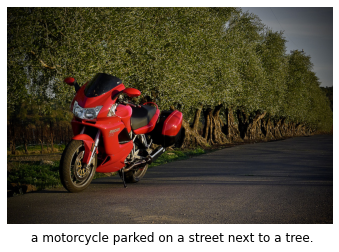

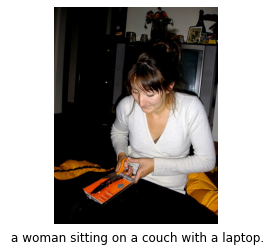

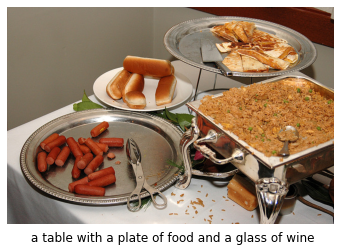

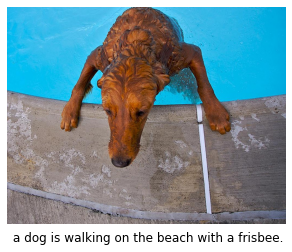

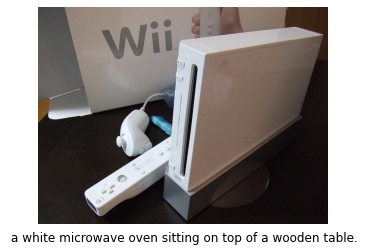

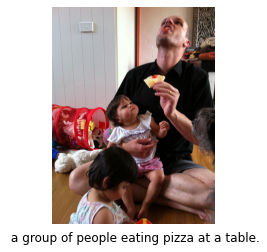

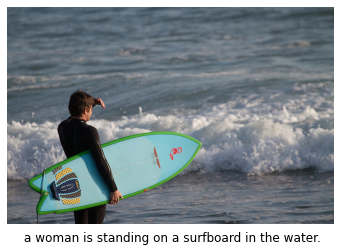

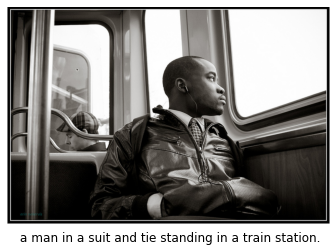

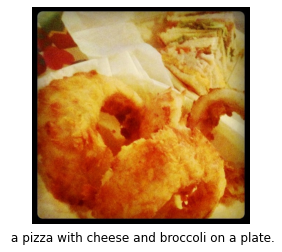

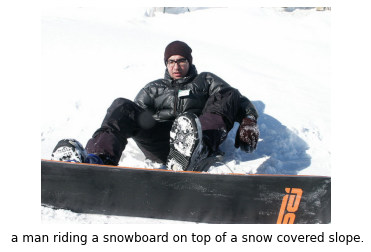

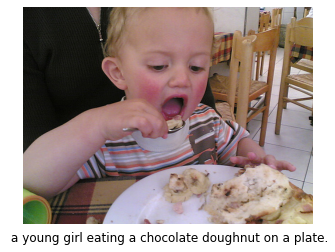

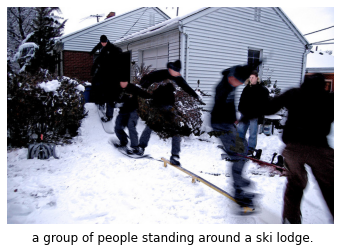

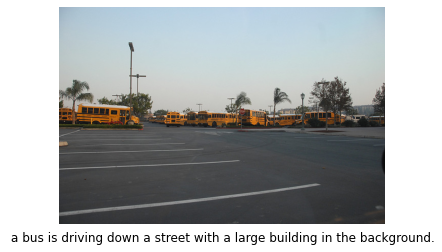

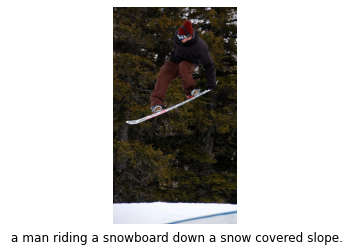

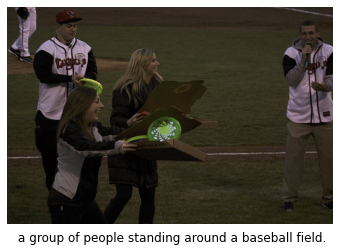

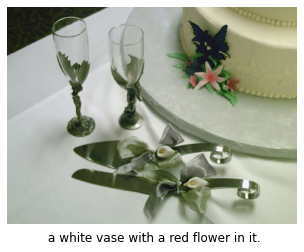

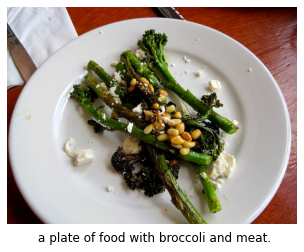

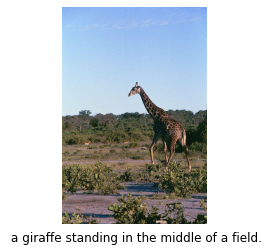

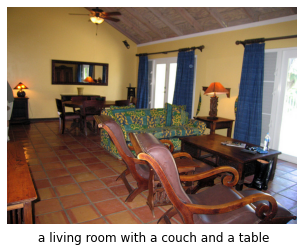

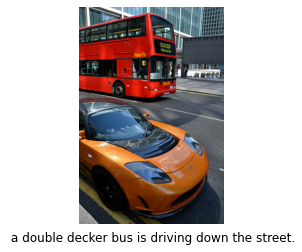

In [12]:
for i in range(20):
    get_prediction(data_loader.dataset.vocab.idx2word, i=i)

## Enjoy Learning!